# Over Sampling Pada Data Bank

## 1. Koneksi ke Database

In [1]:
import pymysql
import pandas as pd
import sys

# Konfigurasi koneksi
host = "localhost"
user = "root" # Ganti sesuai user MySQL kamu
password = "" # Ganti sesuai password MySQL kamu
database = "psd"  # Nama database Anda
table = "bank"       # Nama tabel

df_bank = None
connection = None

try:
    # Buat koneksi
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )
    print("Koneksi ke database 'psd' berhasil.")

    # Baca data dari tabel 'bank' ke dalam DataFrame 'df_bank'
    query = f"SELECT * FROM {table}"
    df_bank = pd.read_sql(query, connection)
    
    print(f"\nData berhasil dimuat dari tabel '{table}'. Jumlah baris: {len(df_bank)}")
    print("Lima baris pertama data:")
    print(df_bank.head())

    # Penting: Setelah kode ini selesai dijalankan, df_bank harus diakses 
    # di lingkungan kerja (notebook/interpreter) yang sama untuk kode analisis selanjutnya.
    
except Exception as e:
    print(f"Error saat koneksi atau mengambil data: {e}")
    sys.exit(1) # Keluar dari program jika terjadi error

finally:
    # Pastikan koneksi ditutup
    if connection:
        connection.close()
        print("\nKoneksi database ditutup.")

Koneksi ke database 'psd' berhasil.



Data berhasil dimuat dari tabel 'bank'. Jumlah baris: 4521
Lima baris pertama data:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Koneksi database ditutup.

C:\Users\FIKRI\AppData\Local\Temp\ipykernel_22468\3076612102.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_bank = pd.read_sql(query, connection)


## 2. Scatter Plot dan Bar Chart

Membuat Scatter Plot dan Bar Chart untuk mengetahui data sudah seimbang atau tidak

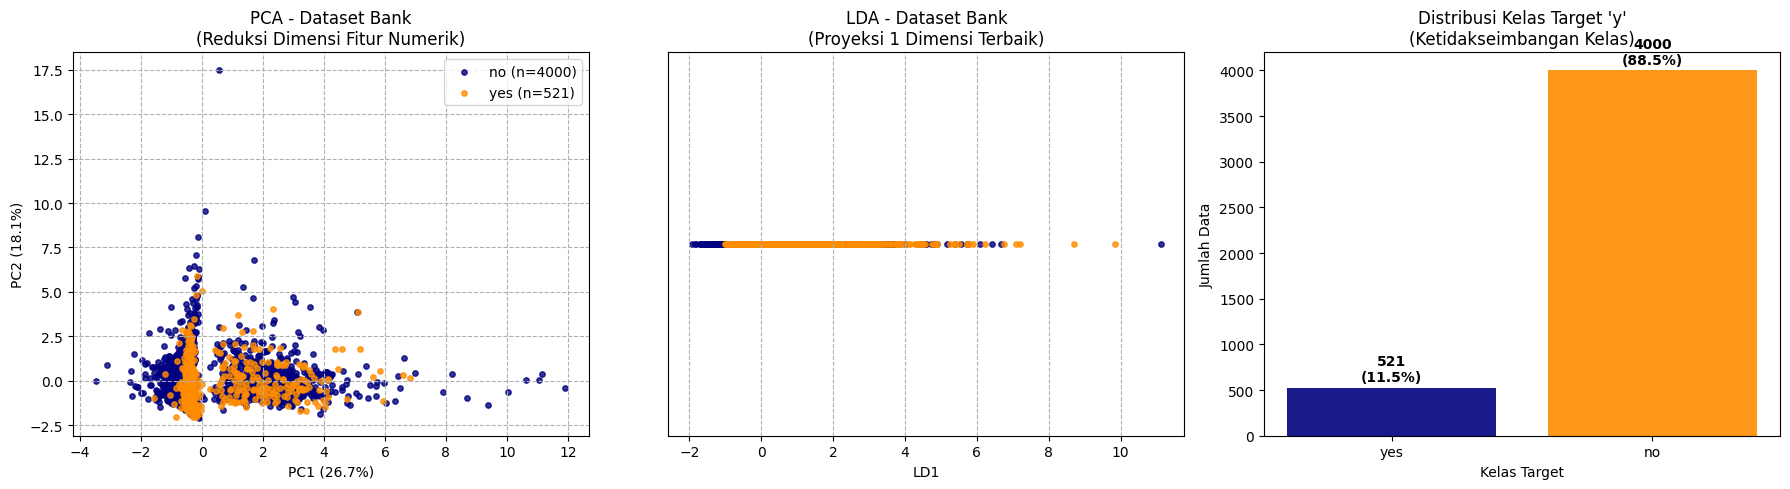


--- Ringkasan Hasil ---
Proporsi kelas 'yes' (target minoritas): 11.52%
Total variance dijelaskan oleh 2 PC: 0.4480


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Asumsikan: df_bank sudah ada di memori dari langkah sebelumnya

# === 2. ANALISIS DATASET BANK (PCA & LDA) ===
if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Jalankan kode koneksi database terlebih dahulu.")
    exit()

# Kolom fitur numerik yang akan digunakan untuk PCA/LDA
FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# Kolom target
TARGET_COLUMN = 'y'

# Ambil nilai fitur dan target
X_db = df_bank[FEATURE_COLUMNS].values
y_db = df_bank[TARGET_COLUMN].values

# Mapping Kelas Target (yes/no)
species_mapping = {
    'no': 0, 
    'yes': 1
}
y_numeric = np.array([species_mapping[s] for s in y_db])
target_names_db = list(species_mapping.keys())
colors = ["navy", "darkorange"]
num_classes = len(target_names_db)

# Standardisasi Data (Penting untuk PCA/LDA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_db)

# --- PCA (2 dimensi) ---
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit(X_scaled).transform(X_scaled)

# --- LDA (max 1 dimensi untuk 2 kelas) ---
# Karena 2 kelas, max n_components = 1
lda_db = LinearDiscriminantAnalysis(n_components=1) 
X_r2_db = lda_db.fit(X_scaled, y_numeric).transform(X_scaled)


# =========================================================================
# === 3. VISUALISASI HASIL ===
# =========================================================================
plt.figure(figsize=(18, 5))

# ---- Plot PCA ----
plt.subplot(1, 3, 1)
for color, i, target_name in zip(colors, range(num_classes), target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r_db[mask, 0], X_r_db[mask, 1],
                color=color, alpha=0.8, s=15,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA - Dataset Bank\n(Reduksi Dimensi Fitur Numerik)")
plt.xlabel(f"PC1 ({pca_db.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_db.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True, linestyle='--')

# ---- Plot LDA (1 Dimensi) ----
plt.subplot(1, 3, 2)
for color, i, target_name in zip(colors, range(num_classes), target_names_db):
    mask = y_numeric == i
    # Plot sebagai titik di garis lurus (y = 0)
    plt.scatter(X_r2_db[mask, 0], np.zeros_like(X_r2_db[mask, 0]),
                color=color, alpha=0.8, s=15,
                label=f"{target_name} (n={np.sum(mask)})")
plt.yticks([]) # Hilangkan sumbu Y
plt.title("LDA - Dataset Bank\n(Proyeksi 1 Dimensi Terbaik)")
plt.xlabel("LD1")
plt.grid(axis='x', linestyle='--')


# ---- Plot distribusi kelas (untuk melihat ketidakseimbangan) ----
plt.subplot(1, 3, 3)
species_counts = df_bank[TARGET_COLUMN].value_counts().sort_index(ascending=False)
plt.bar(species_counts.index, species_counts.values,
        color=colors, alpha=0.9)
plt.title("Distribusi Kelas Target 'y'\n(Ketidakseimbangan Kelas)")
plt.xlabel("Kelas Target")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=0)

total_data = species_counts.sum()
for i, v in enumerate(species_counts.index):
    count = species_counts[v]
    percentage = count / total_data * 100
    plt.text(i, count + (species_counts.values.max() * 0.01), 
             f"{count}\n({percentage:.1f}%)", 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n--- Ringkasan Hasil ---")
print(f"Proporsi kelas 'yes' (target minoritas): {species_counts['yes']/total_data:.2%}")
print(f"Total variance dijelaskan oleh 2 PC: {pca_db.explained_variance_ratio_.sum():.4f}")

## 3. Imbalanced Data dengan Smote

jika pada data terjadi ketidak seimbbangan data maka kita harus menyeimbangkan data tersebut dengan teknik Smote lengkap dengan Scatter Plot serta Bar Chart

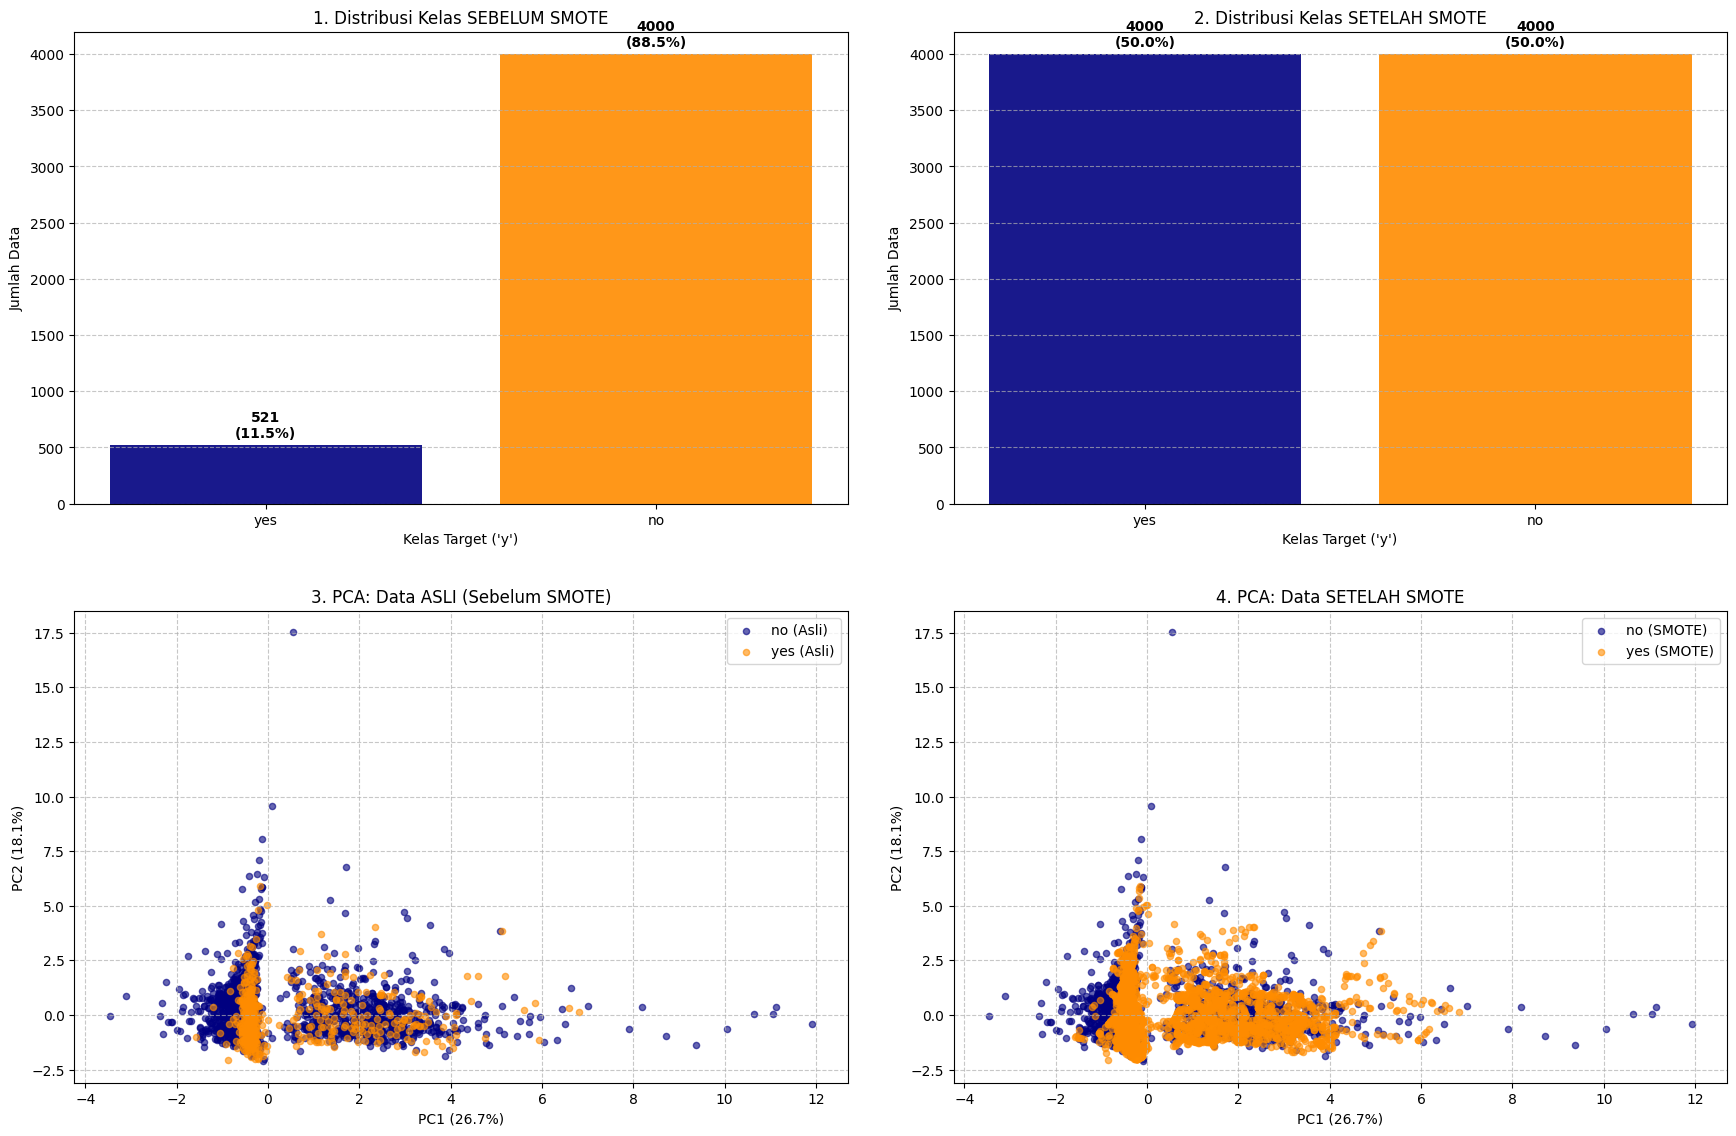


--- Ringkasan SMOTE ---
Distribusi kelas sebelum SMOTE: Counter({0: 4000, 1: 521})
Distribusi kelas setelah SMOTE: Counter({0: 4000, 1: 4000})
Jumlah data sebelum SMOTE: 4521
Jumlah data setelah SMOTE: 8000


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter 

# =========================================================================
# === 1. PERSIAPAN DATA (Asumsi df_bank sudah dimuat) ===
# =========================================================================

if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Jalankan kode koneksi database terlebih dahulu.")
    exit()

FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
TARGET_COLUMN = 'y'
colors = ["navy", "darkorange"] # Warna untuk kelas 'no' (0) dan 'yes' (1)
target_names_db = ['no', 'yes']
num_classes = len(target_names_db)

# Data Awal
X_original = df_bank[FEATURE_COLUMNS].values
y_original_raw = df_bank[TARGET_COLUMN].values
species_mapping = {'no': 0, 'yes': 1} # Mapping ke numerik
y_original_numeric = np.array([species_mapping[s] for s in y_original_raw])


# 2. Standardisasi Data Awal
scaler = StandardScaler()
X_scaled_original = scaler.fit_transform(X_original)

# 3. Penerapan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled_original, y_original_numeric)


# 4. Reduksi Dimensi dengan PCA untuk Visualisasi
# Penting: Fit PCA hanya pada data ORIGINAL (atau data TRAIN jika sudah split)
# Kemudian transform data original dan resampled menggunakan PCA yang sama
pca_visualizer = PCA(n_components=2, random_state=42)
X_pca_original = pca_visualizer.fit_transform(X_scaled_original)
X_pca_resampled = pca_visualizer.transform(X_resampled) # Terapkan transformasi yang sama ke data resampled

# =========================================================================
# === 5. VISUALISASI PERBANDINGAN (4 PLOTS) ===
# =========================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # 2 baris, 2 kolom untuk 4 plot

# ---- Plot 1 (Top-Left): Distribusi Kelas SEBELUM SMOTE (Bar Chart) ----
original_counts = df_bank[TARGET_COLUMN].value_counts().sort_index(ascending=False)
axes[0, 0].bar(original_counts.index, original_counts.values, color=colors, alpha=0.9)
axes[0, 0].set_title("1. Distribusi Kelas SEBELUM SMOTE")
axes[0, 0].set_xlabel("Kelas Target ('y')")
axes[0, 0].set_ylabel("Jumlah Data")
total_original = original_counts.sum()
for i, v in enumerate(original_counts.index):
    count = original_counts[v]
    axes[0, 0].text(i, count + (original_counts.max() * 0.01), 
                 f"{count}\n({count/total_original:.1%})", 
                 ha='center', va='bottom', fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)


# ---- Plot 2 (Top-Right): Distribusi Kelas SETELAH SMOTE (Bar Chart) ----
balanced_counts = pd.Series([target_names_db[i] for i in y_resampled]).value_counts().sort_index(ascending=False)
axes[0, 1].bar(balanced_counts.index, balanced_counts.values, color=colors, alpha=0.9)
axes[0, 1].set_title("2. Distribusi Kelas SETELAH SMOTE")
axes[0, 1].set_xlabel("Kelas Target ('y')")
axes[0, 1].set_ylabel("Jumlah Data")
total_balanced = balanced_counts.sum()
for i, v in enumerate(balanced_counts.index):
    count = balanced_counts[v]
    axes[0, 1].text(i, count + (balanced_counts.max() * 0.01), 
                 f"{count}\n({count/total_balanced:.1%})", 
                 ha='center', va='bottom', fontweight='bold')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)


# ---- Plot 3 (Bottom-Left): Scatter Plot PCA Data ASLI ----
for color_idx, i, target_name in zip(colors, range(num_classes), target_names_db):
    mask_orig = y_original_numeric == i
    axes[1, 0].scatter(X_pca_original[mask_orig, 0], X_pca_original[mask_orig, 1],
                       color=color_idx, marker='o', alpha=0.6, s=20,
                       label=f"{target_name} (Asli)")
axes[1, 0].set_title("3. PCA: Data ASLI (Sebelum SMOTE)")
axes[1, 0].set_xlabel(f"PC1 ({pca_visualizer.explained_variance_ratio_[0]*100:.1f}%)")
axes[1, 0].set_ylabel(f"PC2 ({pca_visualizer.explained_variance_ratio_[1]*100:.1f}%)")
axes[1, 0].legend(loc="best")
axes[1, 0].grid(True, linestyle='--', alpha=0.7)


# ---- Plot 4 (Bottom-Right): Scatter Plot PCA Data SETELAH SMOTE ----
for color_idx, i, target_name in zip(colors, range(num_classes), target_names_db):
    mask_resampled = y_resampled == i
    axes[1, 1].scatter(X_pca_resampled[mask_resampled, 0], X_pca_resampled[mask_resampled, 1],
                       color=color_idx, marker='o', alpha=0.6, s=20,
                       label=f"{target_name} (SMOTE)")
axes[1, 1].set_title("4. PCA: Data SETELAH SMOTE")
axes[1, 1].set_xlabel(f"PC1 ({pca_visualizer.explained_variance_ratio_[0]*100:.1f}%)")
axes[1, 1].set_ylabel(f"PC2 ({pca_visualizer.explained_variance_ratio_[1]*100:.1f}%)")
axes[1, 1].legend(loc="best")
axes[1, 1].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout(pad=3.0) # Sesuaikan padding antar subplot
plt.show()

print("\n--- Ringkasan SMOTE ---")
print(f"Distribusi kelas sebelum SMOTE: {Counter(y_original_numeric)}")
print(f"Distribusi kelas setelah SMOTE: {Counter(y_resampled)}")
print(f"Jumlah data sebelum SMOTE: {len(X_original)}")
print(f"Jumlah data setelah SMOTE: {len(X_resampled)}")

## 4. Melakukan Klasifikasi Pada Data Asli dan Data yang Sudah Diseimbangkan Dengan Smote

## => Klasifikasi dengan Metode Naive Bayes pada data asli dan data yang sudah diseimbangkan

Distribusi kelas di Training Set ASLI: Counter({0: 2799, 1: 365})
Distribusi kelas di Training Set SETELAH SMOTE: Counter({0: 2799, 1: 2799})

HASIL KLASIFIKASI MODEL TUNGGAL: Naive Bayes (GaussianNB)


--- RINGKASAN METRIK: Original Data (Belum SMOTE) ---
AUC Score: 0.7817
Recall (Kelas 'Yes'): 0.3654
F1-Score (Kelas 'Yes'): 0.3608

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.92      0.91      0.92      1201
         Yes       0.36      0.37      0.36       156

    accuracy                           0.85      1357
   macro avg       0.64      0.64      0.64      1357
weighted avg       0.85      0.85      0.85      1357


--- RINGKASAN METRIK: SMOTE Data (Sudah SMOTE) ---
AUC Score: 0.7708
Recall (Kelas 'Yes'): 0.6731
F1-Score (Kelas 'Yes'): 0.4175

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.95      0.80      0.87      1201
         Yes       0.30      0.67  

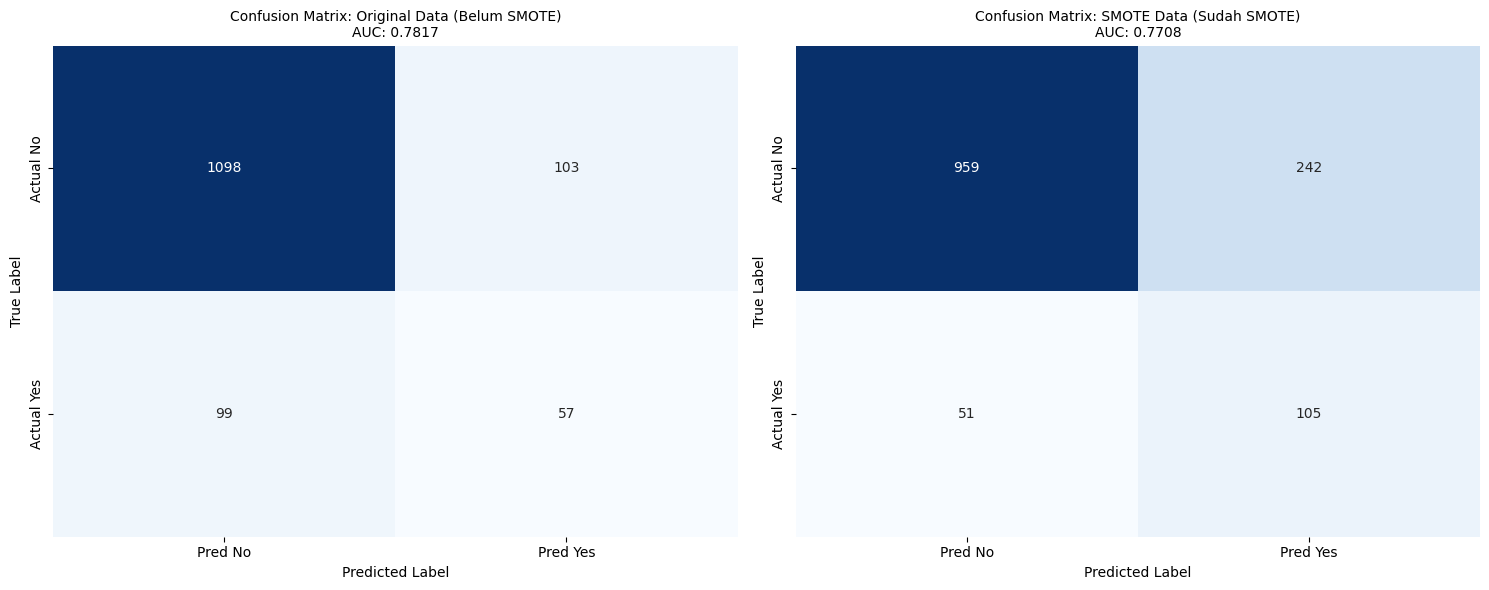

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys

# =========================================================================
# === 1. PERSIAPAN DATA (Asumsi df_bank sudah dimuat) ===
# =========================================================================

# Cek ketersediaan df_bank
if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Harap jalankan kode koneksi database terlebih dahulu.")
    sys.exit(1)

FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
TARGET_COLUMN = 'y'
RANDOM_STATE = 42
MODEL_NAME = "Naive Bayes (GaussianNB)"

# Ambil data dan mapping
df_bank['y_numeric'] = df_bank[TARGET_COLUMN].map({'no': 0, 'yes': 1})
X = df_bank[FEATURE_COLUMNS].values
y = df_bank['y_numeric'].values

# Pisahkan Data (Train dan Test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Standardisasi Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test)


# =========================================================================
# === 2. PEMBUATAN DATASET SMOTE & MODEL NAIVE BAYES ===
# =========================================================================

# Dataset ASLI
X_train_original = X_train_scaled
y_train_original = y_train_orig

# Dataset SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_orig)

print(f"Distribusi kelas di Training Set ASLI: {Counter(y_train_original)}")
print(f"Distribusi kelas di Training Set SETELAH SMOTE: {Counter(y_train_smote)}")


datasets = {
    "Original Data (Belum SMOTE)": (X_train_original, y_train_original),
    "SMOTE Data (Sudah SMOTE)": (X_train_smote, y_train_smote)
}


# =========================================================================
# === 3. PELATIHAN DAN EVALUASI ===
# =========================================================================

results = {}

for data_name, (X_train, y_train) in datasets.items():
    
    model = GaussianNB()
    
    # Pelatihan Model
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Simpan Hasil
    key = f"{data_name}"
    results[key] = {
        "y_pred": y_pred,
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['No', 'Yes'], output_dict=True),
        "AUC Score": roc_auc_score(y_test, y_proba)
    }

# =========================================================================
# === 4. MENAMPILKAN OUTPUT PERBANDINGAN LENGKAP ===
# =========================================================================

print("\n" + "="*80)
print(f"HASIL KLASIFIKASI MODEL TUNGGAL: {MODEL_NAME}")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
plot_idx = 0

for key, res in results.items():
    
    report = res["Classification Report"]
    
    # --- MENAMPILKAN RINGKASAN TEKS ---
    print(f"\n--- RINGKASAN METRIK: {key} ---")
    print(f"AUC Score: {res['AUC Score']:.4f}")
    print(f"Recall (Kelas 'Yes'): {report['Yes']['recall']:.4f}")
    print(f"F1-Score (Kelas 'Yes'): {report['Yes']['f1-score']:.4f}")
    
    # --- MENAMPILKAN CLASSIFICATION REPORT LENGKAP ---
    print("\nClassification Report LENGKAP:")
    # Menggunakan y_pred yang sudah tersimpan
    print(classification_report(y_test, res["y_pred"], target_names=['No', 'Yes'], zero_division=0))

    # --- MENAMPILKAN CONFUSION MATRIX (Visual) ---
    cm = res["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[plot_idx],
                xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
    
    axes[plot_idx].set_title(f"Confusion Matrix: {key}\nAUC: {res['AUC Score']:.4f}", fontsize=10)
    axes[plot_idx].set_xlabel("Predicted Label")
    axes[plot_idx].set_ylabel("True Label")
    
    plot_idx += 1

plt.tight_layout()
plt.show()

## => Klasifikasi dengan Metode SVM pada data asli dan data yang sudah diseimbangkan

Distribusi kelas di Training Set ASLI: Counter({0: 2799, 1: 365})
Distribusi kelas di Training Set SETELAH SMOTE: Counter({0: 2799, 1: 2799})



HASIL KLASIFIKASI MODEL TUNGGAL: Support Vector Machine (SVC)


--- RINGKASAN METRIK: Original Data (Belum SMOTE) ---
AUC Score: 0.7569
Recall (Kelas 'Yes'): 0.1026
F1-Score (Kelas 'Yes'): 0.1711

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.89      0.99      0.94      1201
         Yes       0.52      0.10      0.17       156

    accuracy                           0.89      1357
   macro avg       0.71      0.55      0.55      1357
weighted avg       0.85      0.89      0.85      1357


--- RINGKASAN METRIK: SMOTE Data (Sudah SMOTE) ---
AUC Score: 0.8389
Recall (Kelas 'Yes'): 0.7244
F1-Score (Kelas 'Yes'): 0.4556

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.96      0.81      0.88      1201
         Yes       0.33      0.72      0.46       156

    accuracy                           0.80      1357
   macro avg       0.65      0.77      0.67      1357
weighted a

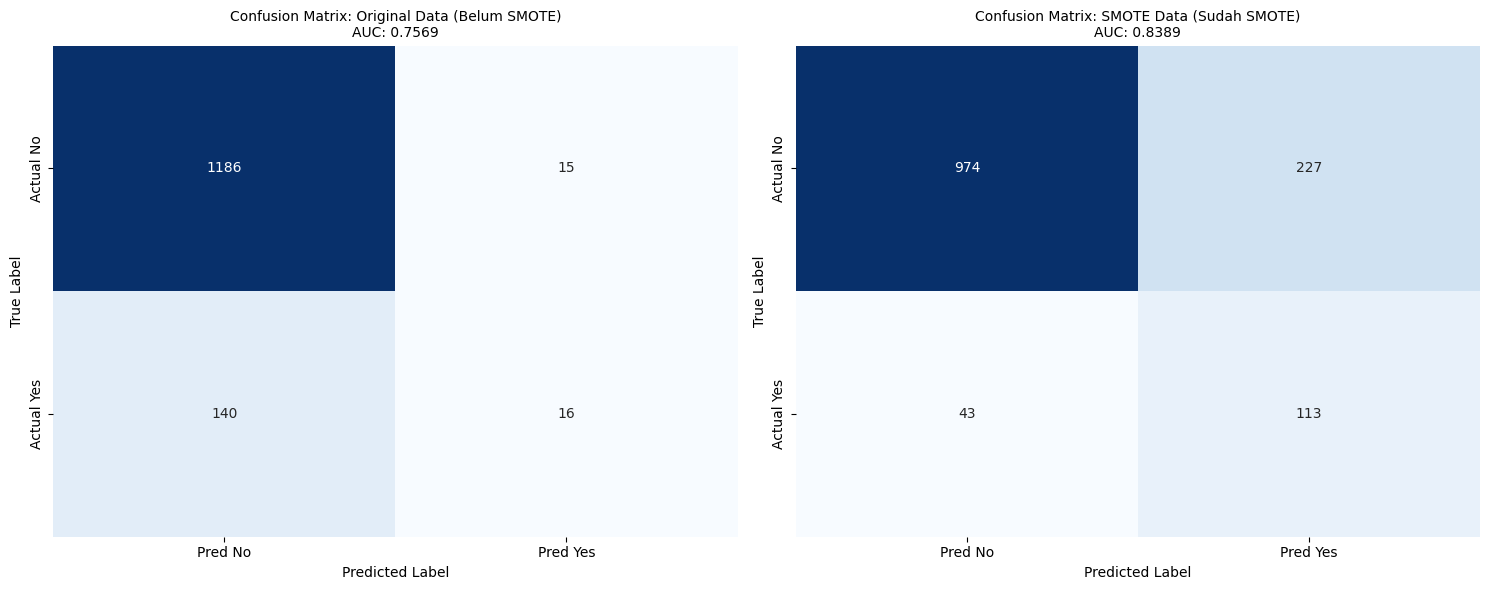

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys

# =========================================================================
# === 1. PERSIAPAN DATA (Asumsi df_bank sudah dimuat) ===
# =========================================================================

# Cek ketersediaan df_bank
if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Harap jalankan kode koneksi database terlebih dahulu.")
    sys.exit(1)

FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
TARGET_COLUMN = 'y'
RANDOM_STATE = 42
MODEL_NAME = "Support Vector Machine (SVC)"

# Ambil data dan mapping
df_bank['y_numeric'] = df_bank[TARGET_COLUMN].map({'no': 0, 'yes': 1})
X = df_bank[FEATURE_COLUMNS].values
y = df_bank['y_numeric'].values

# Pisahkan Data (Train dan Test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Standardisasi Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test)


# =========================================================================
# === 2. PEMBUATAN DATASET SMOTE & MODEL SVM ===
# =========================================================================

# Dataset ASLI (Belum SMOTE)
X_train_original = X_train_scaled
y_train_original = y_train_orig

# Dataset SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_orig)

print(f"Distribusi kelas di Training Set ASLI: {Counter(y_train_original)}")
print(f"Distribusi kelas di Training Set SETELAH SMOTE: {Counter(y_train_smote)}")


datasets = {
    "Original Data (Belum SMOTE)": (X_train_original, y_train_original),
    "SMOTE Data (Sudah SMOTE)": (X_train_smote, y_train_smote)
}


# =========================================================================
# === 3. PELATIHAN DAN EVALUASI ===
# =========================================================================

results = {}

for data_name, (X_train, y_train) in datasets.items():
    
    # probability=True diperlukan untuk menghitung AUC
    model = SVC(probability=True, random_state=RANDOM_STATE)
    
    # Pelatihan Model
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Simpan Hasil
    key = f"{data_name}"
    results[key] = {
        "y_pred": y_pred,                                        # Simpan y_pred
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['No', 'Yes'], output_dict=True),
        "AUC Score": roc_auc_score(y_test, y_proba)
    }

# =========================================================================
# === 4. MENAMPILKAN OUTPUT PERBANDINGAN LENGKAP ===
# =========================================================================

print("\n" + "="*80)
print(f"HASIL KLASIFIKASI MODEL TUNGGAL: {MODEL_NAME}")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
plot_idx = 0

for key, res in results.items():
    
    # Menampilkan Teks Ringkasan
    print(f"\n--- RINGKASAN METRIK: {key} ---")
    report = res["Classification Report"]
    
    print(f"AUC Score: {res['AUC Score']:.4f}")
    print(f"Recall (Kelas 'Yes'): {report['Yes']['recall']:.4f}")
    print(f"F1-Score (Kelas 'Yes'): {report['Yes']['f1-score']:.4f}")
    
    # Menampilkan Classification Report lengkap
    print("\nClassification Report LENGKAP:")
    print(classification_report(y_test, res["y_pred"], target_names=['No', 'Yes'], zero_division=0))

    # Menampilkan Confusion Matrix (Visual)
    cm = res["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[plot_idx],
                xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
    
    axes[plot_idx].set_title(f"Confusion Matrix: {key}\nAUC: {res['AUC Score']:.4f}", fontsize=10)
    axes[plot_idx].set_xlabel("Predicted Label")
    axes[plot_idx].set_ylabel("True Label")
    
    plot_idx += 1

plt.tight_layout()
plt.show()

## 5. Melakukan Bagging Klasifikasi pada Data Asli dan Data yang Sudah Diseimbangkan dengan Smote.

## => Bagging klasifikasi dengan menggunakan metode Naive Bayes pada data yang asli dan data yang sudah diseimbangkan

Distribusi kelas di Training Set ASLI: Counter({0: 2799, 1: 365})
Distribusi kelas di Training Set SETELAH SMOTE: Counter({0: 2799, 1: 2799})



HASIL KLASIFIKASI ENSEMBLE: Bagging Naive Bayes


--- RINGKASAN METRIK: Original Data (Belum SMOTE) ---
AUC Score: 0.7882
Recall (Kelas 'Yes'): 0.3718
F1-Score (Kelas 'Yes'): 0.3580

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.92      0.91      0.91      1201
         Yes       0.35      0.37      0.36       156

    accuracy                           0.85      1357
   macro avg       0.63      0.64      0.64      1357
weighted avg       0.85      0.85      0.85      1357


--- RINGKASAN METRIK: SMOTE Data (Sudah SMOTE) ---
AUC Score: 0.7696
Recall (Kelas 'Yes'): 0.6731
F1-Score (Kelas 'Yes'): 0.4150

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.95      0.80      0.87      1201
         Yes       0.30      0.67      0.42       156

    accuracy                           0.78      1357
   macro avg       0.62      0.73      0.64      1357
weighted avg       0.87 

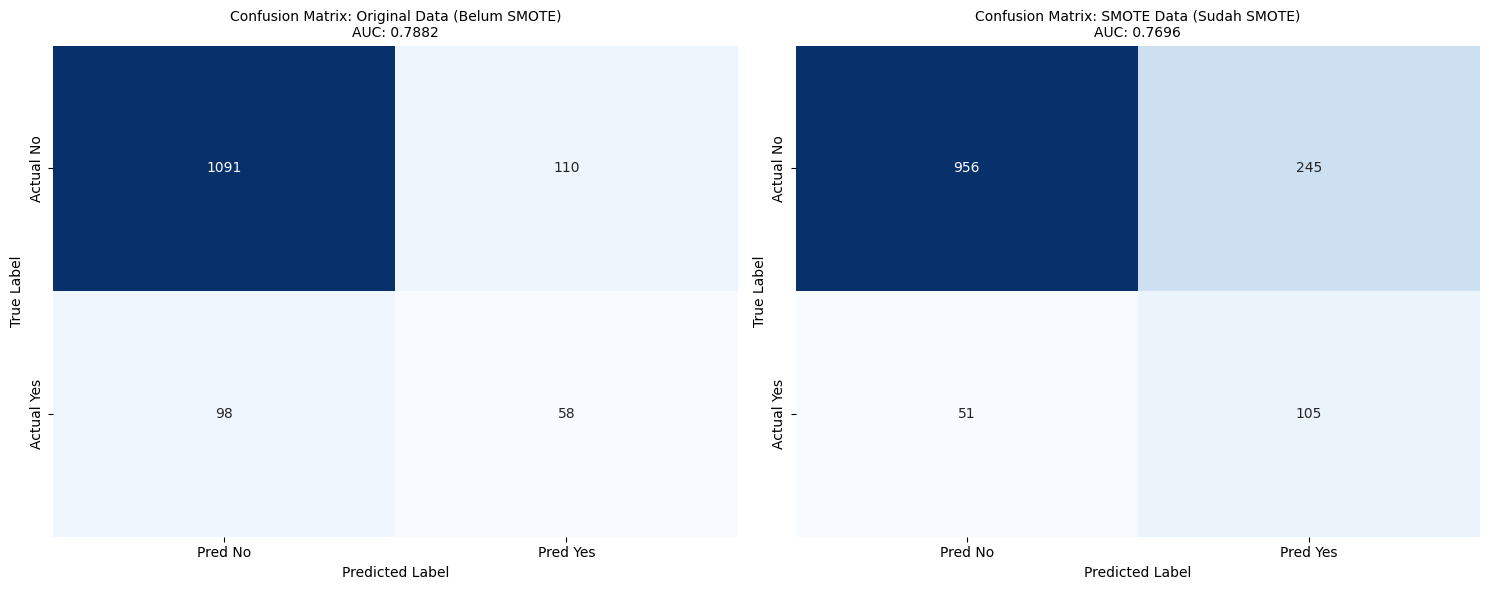

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier # Import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys

# =========================================================================
# === 1. PERSIAPAN DATA (Asumsi df_bank sudah dimuat) ===
# =========================================================================

# Cek ketersediaan df_bank
if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Harap jalankan kode koneksi database terlebih dahulu.")
    sys.exit(1)

FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
TARGET_COLUMN = 'y'
RANDOM_STATE = 42
MODEL_NAME = "Bagging Naive Bayes"

# Ambil data dan mapping
df_bank['y_numeric'] = df_bank[TARGET_COLUMN].map({'no': 0, 'yes': 1})
X = df_bank[FEATURE_COLUMNS].values
y = df_bank['y_numeric'].values

# Pisahkan Data (Train dan Test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Standardisasi Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test)


# =========================================================================
# === 2. PEMBUATAN DATASET SMOTE & DEFINISI MODEL ===
# =========================================================================

# Dataset ASLI
X_train_original = X_train_scaled
y_train_original = y_train_orig

# Dataset SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_orig)

print(f"Distribusi kelas di Training Set ASLI: {Counter(y_train_original)}")
print(f"Distribusi kelas di Training Set SETELAH SMOTE: {Counter(y_train_smote)}")


datasets = {
    "Original Data (Belum SMOTE)": (X_train_original, y_train_original),
    "SMOTE Data (Sudah SMOTE)": (X_train_smote, y_train_smote)
}

# Definisikan BaggingClassifier dengan GaussianNB sebagai estimator
# n_estimators=10 diambil dari template Anda
BASE_ESTIMATOR = GaussianNB()
BAGGING_MODEL = BaggingClassifier(
    estimator=BASE_ESTIMATOR,
    n_estimators=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1 # Menggunakan semua core CPU untuk pelatihan lebih cepat
)


# =========================================================================
# === 3. PELATIHAN DAN EVALUASI ===
# =========================================================================

results = {}

for data_name, (X_train, y_train) in datasets.items():
    
    model = BAGGING_MODEL # Gunakan model Bagging yang sudah didefinisikan
    
    # Pelatihan Model
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Simpan Hasil
    key = f"{data_name}"
    results[key] = {
        "y_pred": y_pred,                                        
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['No', 'Yes'], output_dict=True),
        "AUC Score": roc_auc_score(y_test, y_proba)
    }

# =========================================================================
# === 4. MENAMPILKAN OUTPUT PERBANDINGAN LENGKAP ===
# =========================================================================

print("\n" + "="*80)
print(f"HASIL KLASIFIKASI ENSEMBLE: {MODEL_NAME}")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
plot_idx = 0

for key, res in results.items():
    
    # Menampilkan Teks Ringkasan
    print(f"\n--- RINGKASAN METRIK: {key} ---")
    report = res["Classification Report"]
    
    print(f"AUC Score: {res['AUC Score']:.4f}")
    print(f"Recall (Kelas 'Yes'): {report['Yes']['recall']:.4f}")
    print(f"F1-Score (Kelas 'Yes'): {report['Yes']['f1-score']:.4f}")
    
    # Menampilkan Classification Report lengkap
    print("\nClassification Report LENGKAP:")
    print(classification_report(y_test, res["y_pred"], target_names=['No', 'Yes'], zero_division=0))

    # Menampilkan Confusion Matrix (Visual)
    cm = res["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[plot_idx],
                xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
    
    axes[plot_idx].set_title(f"Confusion Matrix: {key}\nAUC: {res['AUC Score']:.4f}", fontsize=10)
    axes[plot_idx].set_xlabel("Predicted Label")
    axes[plot_idx].set_ylabel("True Label")
    
    plot_idx += 1

plt.tight_layout()
plt.show()

## => Bagging klasifikasi dengan menggunakan metode SVM pada data asli dan data yang sudah diseimbangkan

Distribusi kelas di Training Set ASLI: Counter({0: 2799, 1: 365})
Distribusi kelas di Training Set SETELAH SMOTE: Counter({0: 2799, 1: 2799})



HASIL KLASIFIKASI ENSEMBLE: Bagging SVM


--- RINGKASAN METRIK: Original Data (Belum SMOTE) ---
AUC Score: 0.8014
Recall (Kelas 'Yes'): 0.0897
F1-Score (Kelas 'Yes'): 0.1505

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.89      0.99      0.94      1201
         Yes       0.47      0.09      0.15       156

    accuracy                           0.88      1357
   macro avg       0.68      0.54      0.54      1357
weighted avg       0.84      0.88      0.85      1357


--- RINGKASAN METRIK: SMOTE Data (Sudah SMOTE) ---
AUC Score: 0.8368
Recall (Kelas 'Yes'): 0.7179
F1-Score (Kelas 'Yes'): 0.4553

Classification Report LENGKAP:
              precision    recall  f1-score   support

          No       0.96      0.81      0.88      1201
         Yes       0.33      0.72      0.46       156

    accuracy                           0.80      1357
   macro avg       0.65      0.77      0.67      1357
weighted avg       0.89      0.8

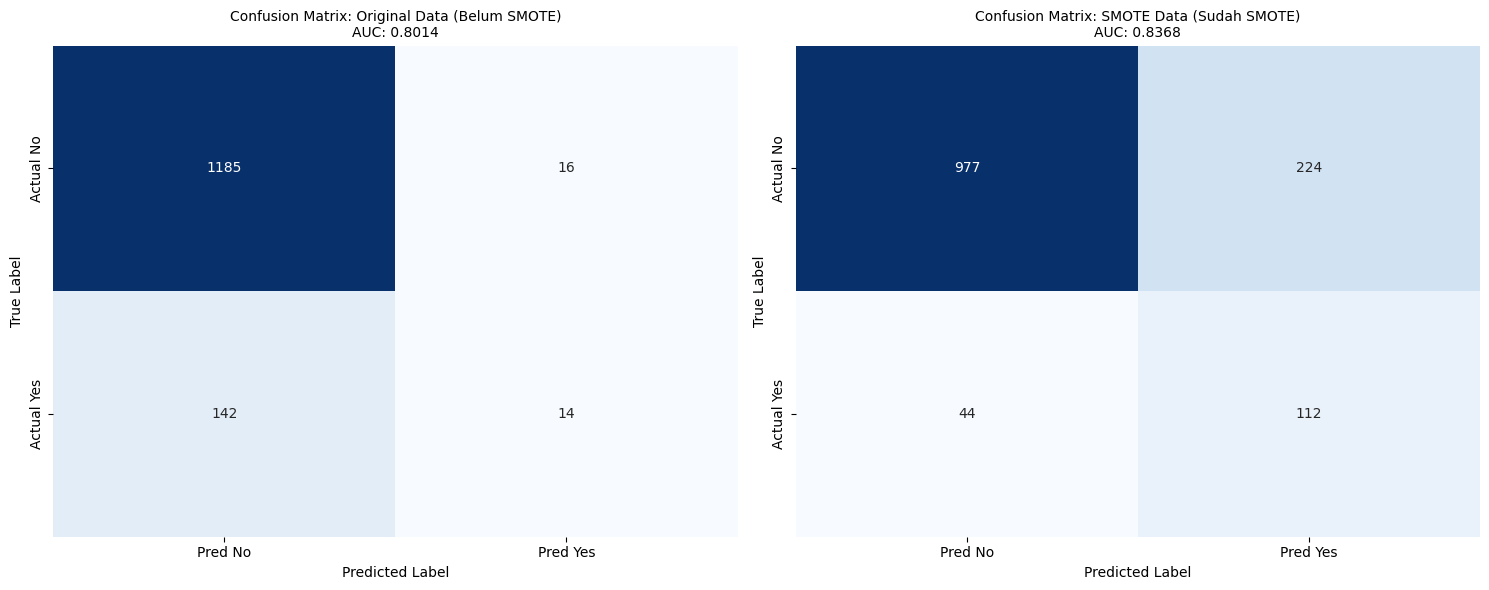

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier # Import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys

# =========================================================================
# === 1. PERSIAPAN DATA (Asumsi df_bank sudah dimuat) ===
# =========================================================================

# Cek ketersediaan df_bank
if 'df_bank' not in locals() and 'df_bank' not in globals():
    print("Error: DataFrame 'df_bank' belum dimuat. Harap jalankan kode koneksi database terlebih dahulu.")
    sys.exit(1)

FEATURE_COLUMNS = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
TARGET_COLUMN = 'y'
RANDOM_STATE = 42
MODEL_NAME = "Bagging SVM"

# Ambil data dan mapping
df_bank['y_numeric'] = df_bank[TARGET_COLUMN].map({'no': 0, 'yes': 1})
X = df_bank[FEATURE_COLUMNS].values
y = df_bank['y_numeric'].values

# Pisahkan Data (Train dan Test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Standardisasi Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test)


# =========================================================================
# === 2. PEMBUATAN DATASET SMOTE & DEFINISI MODEL ===
# =========================================================================

# Dataset ASLI
X_train_original = X_train_scaled
y_train_original = y_train_orig

# Dataset SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_orig)

print(f"Distribusi kelas di Training Set ASLI: {Counter(y_train_original)}")
print(f"Distribusi kelas di Training Set SETELAH SMOTE: {Counter(y_train_smote)}")


datasets = {
    "Original Data (Belum SMOTE)": (X_train_original, y_train_original),
    "SMOTE Data (Sudah SMOTE)": (X_train_smote, y_train_smote)
}

# Definisikan BaggingClassifier dengan SVC sebagai estimator
# SVC(probability=True) wajib untuk AUC, n_estimators=10 diambil dari template Anda
BASE_ESTIMATOR = SVC(probability=True, random_state=RANDOM_STATE) 
BAGGING_MODEL = BaggingClassifier(
    estimator=BASE_ESTIMATOR,
    n_estimators=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1 # Menggunakan semua core CPU untuk pelatihan lebih cepat
)


# =========================================================================
# === 3. PELATIHAN DAN EVALUASI ===
# =========================================================================

results = {}

for data_name, (X_train, y_train) in datasets.items():
    
    model = BAGGING_MODEL # Gunakan model Bagging yang sudah didefinisikan
    
    # Pelatihan Model
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Simpan Hasil
    key = f"{data_name}"
    results[key] = {
        "y_pred": y_pred,                                        
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['No', 'Yes'], output_dict=True),
        "AUC Score": roc_auc_score(y_test, y_proba)
    }

# =========================================================================
# === 4. MENAMPILKAN OUTPUT PERBANDINGAN LENGKAP ===
# =========================================================================

print("\n" + "="*80)
print(f"HASIL KLASIFIKASI ENSEMBLE: {MODEL_NAME}")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
plot_idx = 0

for key, res in results.items():
    
    # Menampilkan Teks Ringkasan
    print(f"\n--- RINGKASAN METRIK: {key} ---")
    report = res["Classification Report"]
    
    print(f"AUC Score: {res['AUC Score']:.4f}")
    print(f"Recall (Kelas 'Yes'): {report['Yes']['recall']:.4f}")
    print(f"F1-Score (Kelas 'Yes'): {report['Yes']['f1-score']:.4f}")
    
    # Menampilkan Classification Report lengkap
    print("\nClassification Report LENGKAP:")
    print(classification_report(y_test, res["y_pred"], target_names=['No', 'Yes'], zero_division=0))

    # Menampilkan Confusion Matrix (Visual)
    cm = res["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[plot_idx],
                xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
    
    axes[plot_idx].set_title(f"Confusion Matrix: {key}\nAUC: {res['AUC Score']:.4f}", fontsize=10)
    axes[plot_idx].set_xlabel("Predicted Label")
    axes[plot_idx].set_ylabel("True Label")
    
    plot_idx += 1

plt.tight_layout()
plt.show()